This is anotebook where you can try and change the source image to easily check the difference

In [1]:
import cv2

import os
import sys
import numpy as np
import aruco
from matplotlib import pyplot as plt
import torch
sys.path.append('..')
from utils import * # Please note that many of the function used in the notebook are located in the utils

In [2]:
# Constants declaration

# Camera configuration
camera_config = "../arucoConfig/baumer12mm1mf.yml"
camparam = aruco.CameraParameters()
camparam.readFromXMLFile(camera_config)

# Configuration of the boxes and creation of marker maps
lower_box_config = "../arucoConfig/block1(lowest).yml"
higher_box_config = "../arucoConfig/block2(highest).yml"
mmap_lowest = aruco.MarkerMap(lower_box_config)
mmap_highest = aruco.MarkerMap(higher_box_config)

# Center of the block
lower_box_center_location = "../arucoConfig/AxisCentreBlock1.csv"
upper_box_center_location = "../arucoConfig/AxisCentreBlock2.csv"

lower_box_loc = np.fromstring(open(lower_box_center_location).read(), sep=' ')[-3:]/1000
upper_box_loc = np.fromstring(open(upper_box_center_location).read(), sep=' ')[-3:]/1000

# Direction of the axis
lower_box_rotation = np.fromstring(open(lower_box_center_location).read(), sep=' ')[:3]
upper_box_rotation = np.fromstring(open(upper_box_center_location).read(), sep=' ')[:3]

In [3]:
def get_frame_from_video(video_location):
    cap = cv2.VideoCapture(video_location)
    ret, frame = cap.read()

    # Try to find a picture with at least 4 markers, marker map would fail otherwise (we need at least 2 markers for each box)
    while ret:
        detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)
        markers = detector.detect(frame)
        mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)
        if mmap_low_p.getRTMatrix().size and mmap_high_p.getRTMatrix().size:
            break
        ret, frame = cap.read()
    return frame

video_location = '../Data/baumer_video0043.avi' # <--- Change video here
image_to_use = get_frame_from_video(video_location)
if image_to_use is None:
    print("2 ArUco markers for 2 boxes couldn't be located, please try another video")

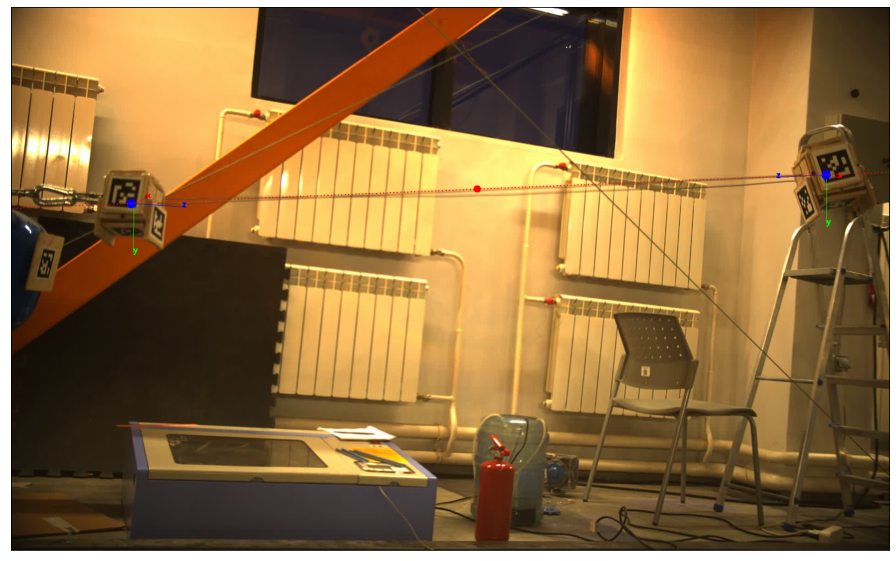

In [4]:
frame_copy = image_to_use.copy()
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame_copy)
mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

aruco.CvDrawingUtils.draw3dAxis(
    frame_copy, camparam, cv2.Rodrigues(lower_box_rotation)[0],
    np.array([get_center_box_pos(mmap_low_p, lower_box_loc)]), .1)

aruco.CvDrawingUtils.draw3dAxis(
    frame_copy, camparam, cv2.Rodrigues(upper_box_rotation)[0],
    np.array([get_center_box_pos(mmap_high_p, upper_box_loc)]), .1)

# Getting 3D position for x, y of the lower and x2,y2 of the upper boxes
x, y = get_2d_from_3d(get_center_box_pos(mmap_low_p, lower_box_loc), camparam.CameraMatrix)
x2,y2 = get_2d_from_3d(get_center_box_pos(mmap_high_p, upper_box_loc), camparam.CameraMatrix)

# Draw their location
img_circles = cv2.circle(frame_copy.copy(),(x,y), 10, [255,0,0], cv2.FILLED)
img_circles = cv2.circle(img_circles, (x2,y2), 10, [255,0,0], cv2.FILLED)


A = get_center_box_pos(mmap_low_p, lower_box_loc) # 3D position of lower marker map
B = get_center_box_pos(mmap_high_p, upper_box_loc) # 3D position of upper marker map

mp = A*0.5+0.5*B # Middle point

# Draw the middle point
img_circles = cv2.circle(img_circles, get_2d_from_3d(mp, camparam.CameraMatrix), 8, [0,0,255], cv2.FILLED)

# We can draw the rest of the line
f = lambda t: B+t*(A-B)
for i in np.arange(-10, 100, step=0.005):
    res = f(i)
    img_circles = cv2.circle(img_circles, get_2d_from_3d(res, camparam.CameraMatrix), 1, [0,0,255], cv2.FILLED)

    
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## Locating the wire

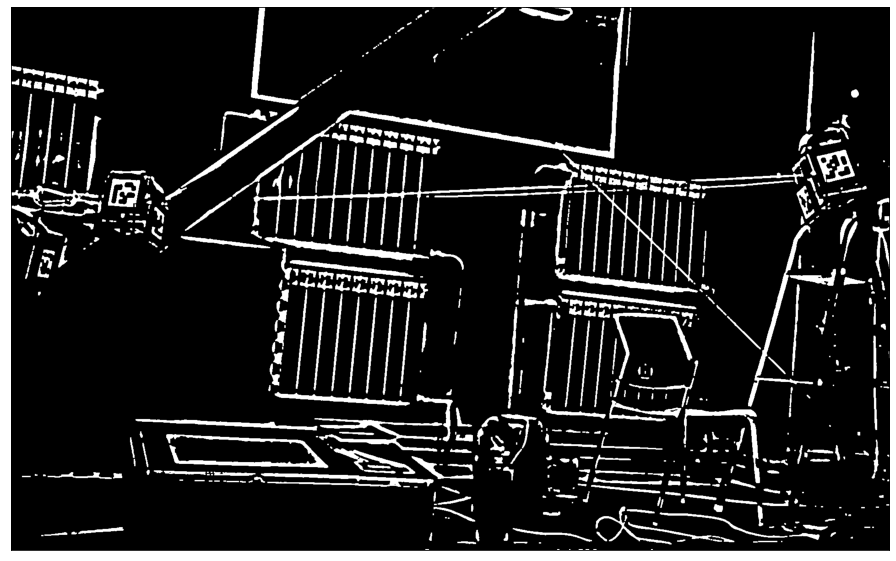

In [5]:
grayed = search_for_line(frame_copy)

# Red wire represents the perfect location of the cable
line_p1 = get_2d_from_3d(A, camparam.CameraMatrix)
line_p2 = get_2d_from_3d(B, camparam.CameraMatrix)
grayed_with_line = cv2.cvtColor(grayed, cv2.COLOR_GRAY2RGB)
grayed_with_line = cv2.line(grayed_with_line,
                             line_p1,
                             line_p2,
                             [255,0,0], 2)

plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

## Locating the line and checking the sagging in pixels

In [6]:
# Find the cable from the 'perfect' line

rays = []
middle_point = int((line_p1[1]+line_p2[1])/2), int((line_p2[0]+line_p1[0])/2) # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while middle_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[middle_point] == [255,255,255]):
        current_ray.add_point(middle_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    middle_point = (middle_point[0]+1, middle_point[1]) 

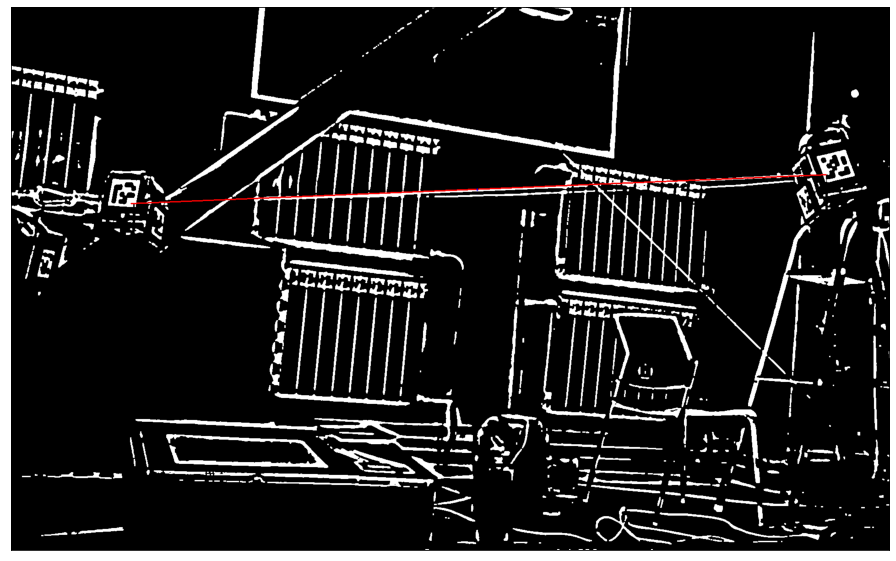

The difference is ~3 pixels to the middle of the cable
Or ~1 pixels from the beginning of the cable
The sagging is ~2.90 mm


In [7]:
new_rays = []
mid_point = get_2d_from_3d(mp, camparam.CameraMatrix)[::-1] # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while mid_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[mid_point] == [255,255,255]):
        current_ray.add_point(mid_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        new_rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    mid_point = (mid_point[0]+1, mid_point[1])
    
start = get_2d_from_3d(mp, camparam.CameraMatrix) # starting point
end = new_rays[0].get_middle() # middle of the cable
grayed_new = cv2.line(grayed_with_line.copy(), start, end, [0,0,255], 2)

plt.figure(figsize=(20,10))
plt.imshow(grayed_new)
plt.xticks([]), plt.yticks([])
plt.show()
print(f"The difference is ~{end[1] - start[1]} pixels to the middle of the cable")
print(f"Or ~{new_rays[0].starting_pos[0]-start[1]} pixels from the beginning of the cable")

lp = mp.copy()
while not get_2d_from_3d(lp, camparam.CameraMatrix) == end:
    lp[1] = lp[1] + 0.0001

points = []
points.append(lp)
while get_2d_from_3d(lp, camparam.CameraMatrix) == end:
    lp[1] = lp[1] + 0.0001
    points.append(lp)
    
tp = points[len(points)//2]
dst = abs((mp[1] - tp[1])*1000)

print("The sagging is ~{:.2f} mm".format(dst))

## The points we have located

In [8]:
def get_middle_y(img, x, y):
    dynamic_y = y
    # Firstly, measure the number of white pixels from the top
    while img[dynamic_y, x] == 255:
        dynamic_y += 1
    height_below = dynamic_y - y

    dynamic_y = y
    # Then measure number of nwhite pixels on the bottom
    while img[dynamic_y, x] == 255:
        dynamic_y -= 1
    height_above = y - dynamic_y

    # Calculate mean
    mean = int((height_below + height_above) / 2)

    # Adjust the y location, so that the number of white pixels at the top and at the bottom is the same
    return y - (height_above - mean)


# Collect points along the line, given the location of the middle of the line
def find_points(img, middle):
    x, y = middle
    h, w = img.shape
    xs = [x]
    ys = [y]

    # Go to through right direction until there is no cable
    tmp_x = x + 1
    tmp_y = y
    while w > tmp_x and h > tmp_y and img[tmp_y, tmp_x] == 255:
        new_y = get_middle_y(img, tmp_x, tmp_y)  # Adjust y to be in the middle
        if (abs(new_y-tmp_y) > 2):
            tmp_x += 1
            continue
        tmp_y = new_y
        xs.append(tmp_x)
        ys.append(tmp_y)
        tmp_x += 1

    # Go throught the left direction until there is no cable
    tmp_x = x - 1
    tmp_y = y
    while w > tmp_x and h > tmp_y and img[tmp_y, tmp_x] == 255:
        new_y = get_middle_y(img, tmp_x, tmp_y)  # Adjust y to be in the middle
        if (abs(new_y-tmp_y) > 2):
            tmp_x -= 1
            continue
        tmp_y = new_y
        xs.append(tmp_x)
        ys.append(tmp_y)
        tmp_x -= 1

    return xs, ys


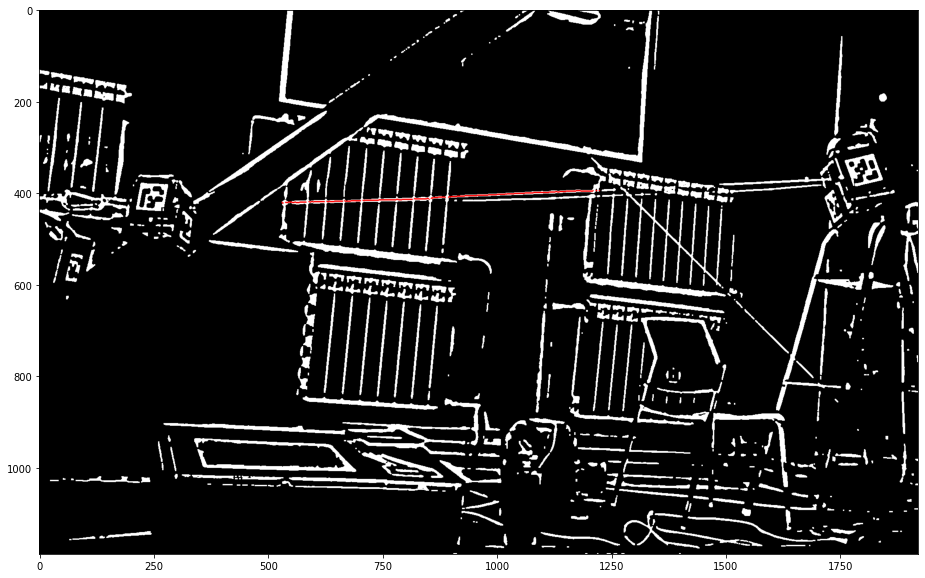

In [9]:
xs, ys = find_points(grayed, rays[0].get_middle())
found_lines = cv2.cvtColor(grayed.copy(), cv2.COLOR_GRAY2RGB)
for x, y in zip(xs, ys):
    cool = cv2.circle(found_lines, (x,y), 1, [255,0,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(found_lines)
plt.show()

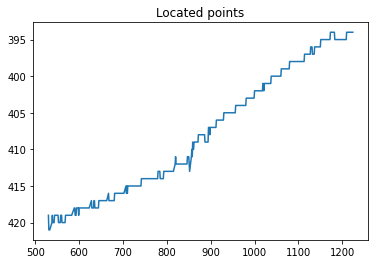

In [10]:
xs, ys = list(zip(*sorted(zip(xs,ys), key=lambda x: x[0])))
plt.plot(xs, ys)
plt.gca().invert_yaxis()
plt.title('Located points')
plt.show()

## Finding Catenary

Given points on the line we can try to predict the catenary

Epoch 0. Loss 12.834104537963867
Epoch 100000. Loss 0.06576375663280487
Epoch 200000. Loss 0.05476515367627144
Epoch 300000. Loss 0.04959048330783844
Epoch 400000. Loss 0.045884665101766586
Fitted arguments are a = 3.4018990993499756, b = 0.0075888377614319324, c = 0.3181478679180145


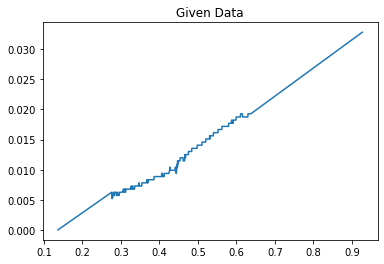

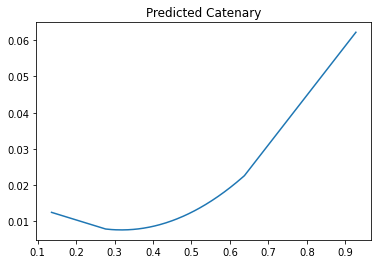

In [25]:
# Construct the ys and xs to be fit
# Consisting of lower and upper points of boxes
x, y = torch.Tensor([line_p1[0], *xs ,line_p2[0]])/1920, torch.Tensor([line_p1[1], *ys ,line_p2[1]])/1920
y = max(y) - y # Invert ys for better representation as in image
cat = CatenaryPredictor(x, y)
a, b, c, sample_ys =cat.solve(500000, 100000) # Fit the catenary

print(f'Fitted arguments are a = {a}, b = {b}, c = {c}')
plt.plot(x, y)
plt.title('Given Data')
plt.show()

plt.plot(list(x), list(sample_ys))
plt.title('Predicted Catenary')
plt.show()

In [28]:
# Calculating the sagging
# Difference between catenary and and perfect line
diff_cat = ((line_p1[1]-line_p2[1])/(2*1920) - lsq_catenary((x[-1]+x[0])/2, a, b, c))
# Difference between y's in 3D image
diff_met = (A[1] - B[1])
# Difference between pixels of 3D converted to 2D
diff_pixels = get_2d_from_3d(A, camparam.CameraMatrix)[1]-get_2d_from_3d(B, camparam.CameraMatrix)[1]

# meters/pixels*pixels = meters of sagging
sag_meters = diff_met/diff_pixels*diff_cat*1920

print("The sagging is ~{:.2f} mm".format(sag_meters*1000))

The sagging is ~3.66 mm


## Simulation

Follows the algorithm described in the report

In [13]:
# Initial values of a, x1 and x2
init_a = a.clone().detach()
init_x1 = x[0].clone().detach()
init_x2 = x[-1].clone().detach()

camera_matrix = torch.Tensor(camparam.CameraMatrix)

In [14]:
sim = Simulation(init_a, init_x1, init_x2, camera_matrix)
a, x_1, x_2, new_u1, new_u2 = sim.simulate()

print(f'Fitted: a={a.item()}, x_1 = {x_1.item()}, x_2 = {x_2.item()}')
print(f'Real values were: a={init_a.item()}, x_1 = {init_x1.item()}, x_2 = {init_x2.item()}')

print(f'Perfect u1 = {sim.perfect_u1.numpy()}, u2 = {sim.perfect_u2.numpy()}')
print(f'Ours u1 = {new_u1.detach().numpy()}, u2 = {new_u2.detach().numpy()}')

Epoch 0. Loss 49.02821350097656
Fitted: a=3.347646474838257, x_1 = 0.18841099739074707, x_2 = 0.9720702767372131
Real values were: a=3.401660919189453, x_1 = 0.13645833730697632, x_2 = 0.9270833134651184
Perfect u1 = [999.19275 663.506  ], u2 = [1015.04016  672.6308 ]
Ours u1 = [999.1925 663.5061], u2 = [1015.6736  671.6169]
